### Loading the cleaned dataset

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")

# TEST
quant = quant[categ.vocal_channel=="speech"].reset_index(drop=True)
categ = categ[categ.vocal_channel == "speech"].reset_index(drop=True)

print(quant.columns)
print(categ.columns)
print(len(categ), len(quant))
display(quant.head())
display(categ.head())

Index(['intensity', 'kur', 'length_ms', 'mean', 'mfcc_max', 'mfcc_mean',
       'mfcc_min', 'mfcc_std', 'sc_kur', 'sc_max', 'sc_mean', 'sc_min',
       'sc_skew', 'sc_std', 'skew', 'stft_kur', 'stft_mean', 'stft_min',
       'stft_skew', 'stft_std', 'zero_crossings_sum', 'log_amp_pp'],
      dtype='object')
Index(['vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'actor', 'sex'],
      dtype='object')
1335 1335


,intensity,kur,length_ms,mean,mfcc_max,mfcc_mean,mfcc_min,mfcc_std,sc_kur,sc_max,...,sc_skew,sc_std,skew,stft_kur,stft_mean,stft_min,stft_skew,stft_std,zero_crossings_sum,log_amp_pp
0,-36.793432,9.406061,3737,3.844916e-07,0.295213,0.364634,0.529265,0.454352,0.123738,0.599230,...,0.325936,0.551824,0.273153,0.184467,0.394443,-4.950095,0.568130,0.689802,16995,-1.845035
1,-33.800066,19.564187,3904,-7.149491e-08,0.511665,0.505299,0.595352,0.417233,0.048477,0.442238,...,0.312511,0.766001,0.292157,0.115827,0.398830,-5.314968,0.522350,0.782470,13906,-1.029642
2,-36.312244,12.775898,3570,2.519818e-07,0.568019,0.470033,0.587051,0.435895,0.124882,0.448644,...,0.456193,0.703584,0.028186,0.231883,0.265849,-5.670364,0.638317,0.743282,12143,-2.120240
3,-37.164888,14.273623,3770,-1.571576e-07,0.663165,0.481463,0.510082,0.497554,0.053512,0.527771,...,0.257982,0.756349,0.011188,0.098895,0.514174,-4.572105,0.415140,0.751991,14239,-1.770932
4,-49.095042,11.289926,3437,-3.640687e-07,0.611559,0.274151,0.280425,0.748127,0.035585,0.442209,...,0.170241,0.674937,0.211353,0.146755,0.535732,-3.631861,0.427193,0.649728,11147,-3.169561


,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,speech,fearful,normal,Dogs are sitting by the door,2nd,22.0,F
3,speech,angry,normal,Dogs are sitting by the door,1st,2.0,F
4,speech,neutral,normal,Dogs are sitting by the door,2nd,8.0,F


### Normalization

In [62]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from pandas import DataFrame

scaler = StandardScaler()

X = quant.values
X = scaler.fit_transform(X)

### PCA

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


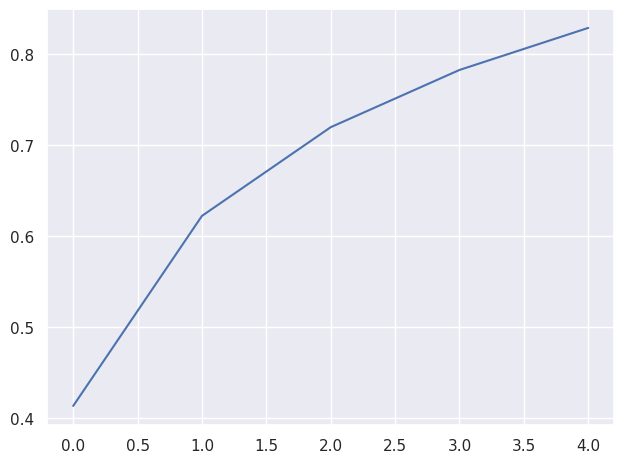

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

scaler = MinMaxScaler()
X = quant.values
X = scaler.fit_transform(X)

pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))


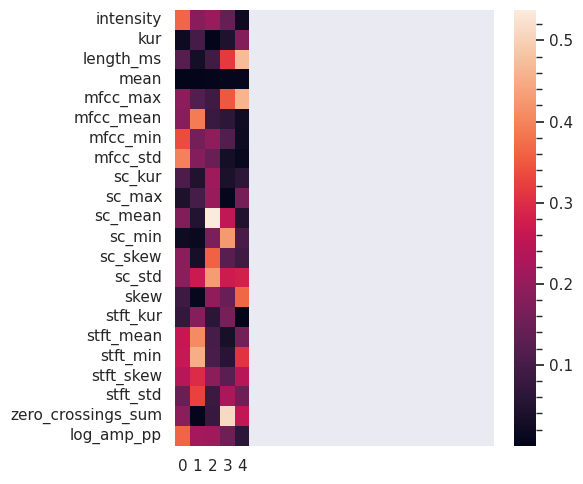

In [64]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(np.abs(pca.components_.T), ax=ax)
plt.yticks(np.arange(len(quant.columns)) + 0.5, labels=quant.columns, rotation=00)
ax.set_xticks(np.arange(len(quant.columns)) + 0.5, minor=False)
print()

per-family PCA

In [65]:
stats = ["max", "min", "mean", "std"]
stats2 = stats + ["kur", "skew"]
mfcc_family = [f"mfcc_{s}" for s in stats]
stft_family = [f"stft_{s}" for s in stats2 if s!="max"]
sc_family = [f"sc_{s}" for s in stats2]
trivial = list(set(quant.columns) - set(stft_family) - set(sc_family) - set(mfcc_family))

feature_to_index = {quant.columns[i]: i for i in range(len(quant.columns))}
def get_indexes(list_of_features):
    return np.vectorize(feature_to_index.get)(list_of_features)

In [66]:
aggregated_quant = pd.DataFrame()
for family, name in zip([mfcc_family, stft_family, sc_family, trivial], ["mfcc", "stft", "sc" ,"trivial"]):
    pca = PCA(n_components=1)
    aggregated_quant[name] = pca.fit_transform(quant[family]).reshape(-1)

In [67]:
for field in aggregated_quant.columns:
    aggregated_quant[field] = MinMaxScaler().fit_transform(aggregated_quant[field].values.reshape(-1,1))
aggregated = categ.join(aggregated_quant)

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


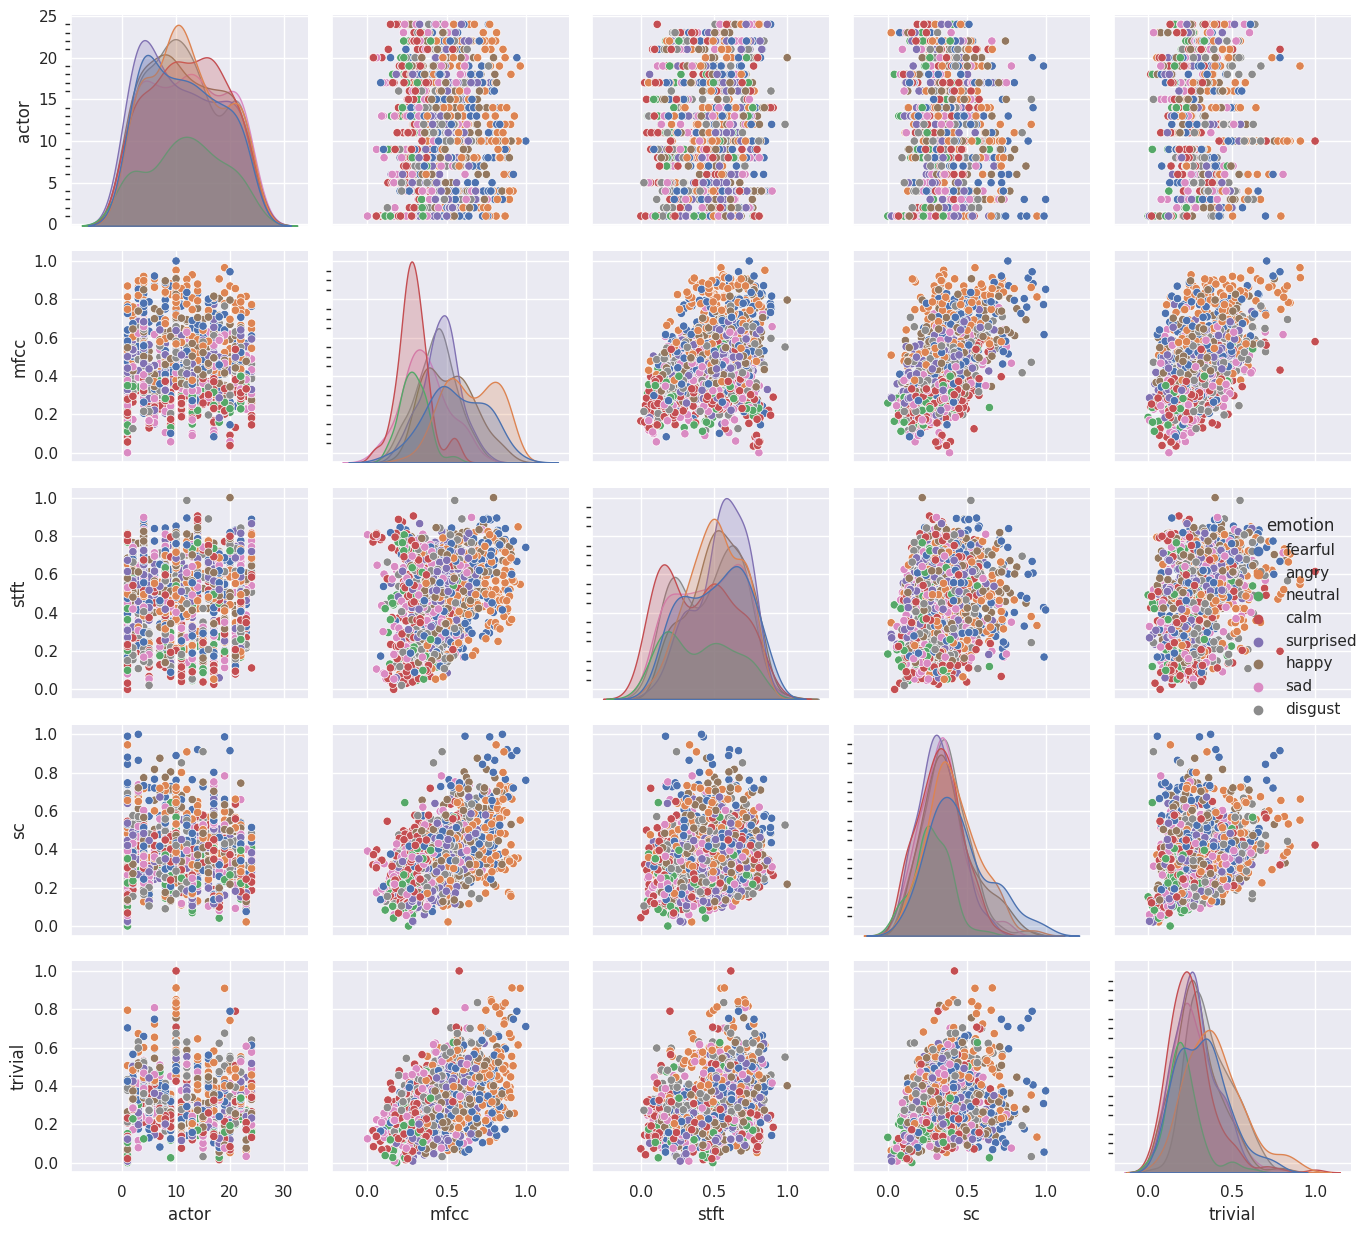

In [68]:
sns.pairplot(data=aggregated, hue="emotion")

# UMAP

In [69]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
import umap 

X = quant.values
scaler = StandardScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=100)
embedding = reducer.fit_transform(X)

In [70]:
embed_df = pd.DataFrame(dict(x=embedding[:,0], y=embedding[:,1]))
embed_cat = embed_df.join(categ)
embed_cat.head()
embed_cat

,x,y,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,7.678051,13.410778,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,8.044161,13.770878,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,8.103560,14.970490,speech,fearful,normal,Dogs are sitting by the door,2nd,22.0,F
3,6.804820,14.168046,speech,angry,normal,Dogs are sitting by the door,1st,2.0,F
4,5.361842,14.617210,speech,neutral,normal,Dogs are sitting by the door,2nd,8.0,F
...,...,...,...,...,...,...,...,...,...
1330,3.714792,10.731404,speech,neutral,normal,Kids are talking by the door,2nd,1.0,M
1331,5.273233,11.045212,speech,surprised,strong,Dogs are sitting by the door,1st,1.0,M
1332,3.077345,12.898015,speech,calm,strong,Kids are talking by the door,1st,23.0,M
1333,2.727807,13.123116,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M


Text(0, 0.5, '')

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


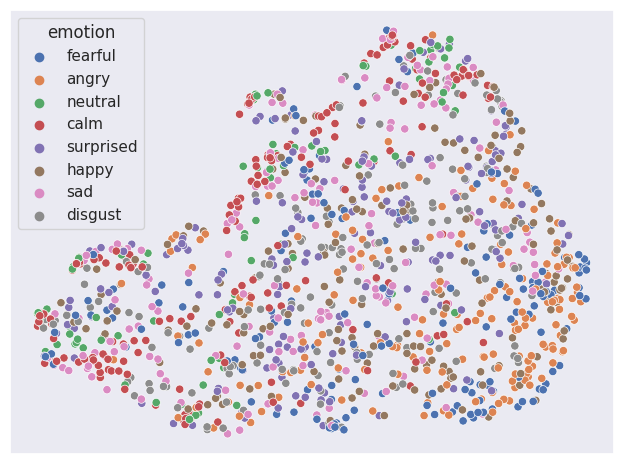

In [71]:
sns.scatterplot(data=embed_cat,x="x", y="y", hue="emotion")
# plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


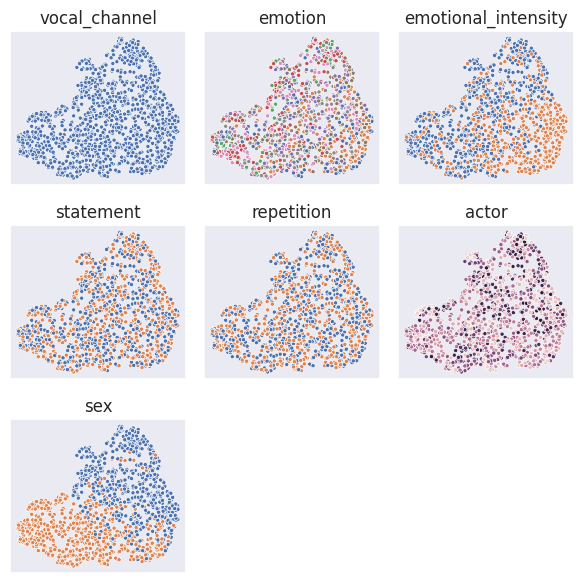

In [72]:
fig, axes = plt.subplots(3,3, figsize=(6,6))
axes=axes.flatten()

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

for ax, cat in zip(axes, categ.columns):
    sns.scatterplot(data=embed_cat, x="x", y="y", hue=cat, marker=".", ax=ax)
    ax.axis("on")
    ax.set_title(cat)
    ax.get_legend().remove()

fig.savefig("UMAP_categ.pdf")

We drop the analysis of `repetition`, `actor` and `statement` by now

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


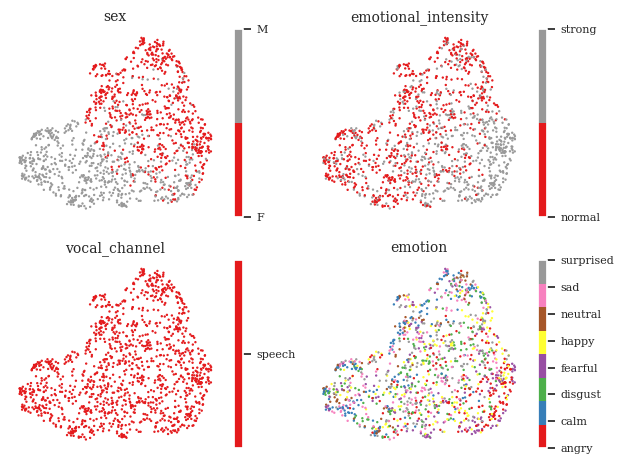

In [73]:
from matplotlib import cm

good_ones = ["sex", "emotional_intensity", "vocal_channel", "emotion"]

fig, axes = plt.subplots(2,2)
axes = axes.flatten()

for ax, cat in zip(axes, good_ones):
    labels = pd.Categorical(categ[cat]).categories
    cmap = cm.get_cmap("Set1", len(labels))
    mappable = ax.scatter(embedding[:,0], embedding[:,1], c=pd.Categorical(categ[cat]).codes,
                cmap=cmap, alpha=1.0, s=0.5)
    ax.set_title(f"{cat}", font={"size":10, "family":"serif"})
    cbar = fig.colorbar(mappable, ax=ax)
    cbar.ax.set_yticks(range(len(labels)))
    cbar.ax.set_yticklabels(labels, font={"size":8, "family":"serif"})
    cbar.ax.tick_params(axis='y', which='minor', right=False)
    ax.axis("off")
fig.tight_layout()
plt.savefig("UMAP.pdf")


## ISOMAP and Minkowski _p_

It can be seen that when $p=1$ ISOMAP shows a big unique spot while when $p=\infty$ even isomap shows two distinct topological areas _even with a standard scaler_


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


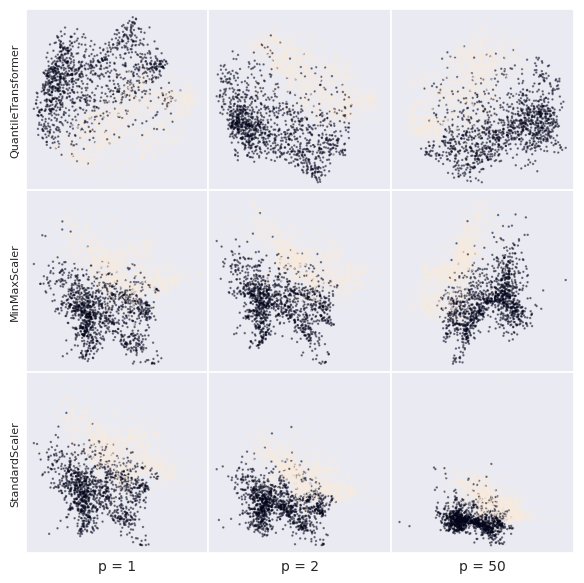

In [57]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from sklearn.manifold import Isomap

scalers = [QuantileTransformer(), MinMaxScaler(), StandardScaler()]
ps = [1,2,50]

fig, axes = plt.subplots(len(scalers),len(ps), figsize=(6,6),gridspec_kw = {'wspace':0, 'hspace':0})

for i, scaler in enumerate(scalers):
    for j, p in enumerate(ps):
        X = quant.values
        X = scaler.fit_transform(X)
        S = Isomap(n_neighbors=5, p=p).fit_transform(X)
        axes[i,j].scatter(S[:,0], S[:,1], c=pd.Categorical(categ.sex).codes, alpha=0.5, s=0.5)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        
        if j == 0:
            axes[i,j].set_ylabel(str(scaler.__class__).split(".")[-1][:-2], font={"size":8})
        if i==2:
            axes[i,j].set_xlabel(f"p = {p}", font={"size":10})
        # axes[i,j].axis("off")
plt.show()